# Data Splitting Validation: Detecting and Preventing Leakage

This notebook validates our data splitting strategy and demonstrates:
1. **Problem**: Data leakage with random splitting
2. **Solution**: Case-based splitting to prevent leakage
3. **Verification**: Ensure no overlap between train/test groups

In [1]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from src.data import load_dataset, prepare_data, prepare_data_by_groups, validate_no_leakage

plt.rcParams['figure.figsize'] = (12, 4)

## 1. Load Dataset and Examine Structure

In [2]:
# Load dataset
data_path = '/Users/juanaguila/Code/neohookean-data-generator/data/consolidated_all.npz'
data = np.load(data_path)

print("Dataset keys:", list(data.keys()))
print("\nDataset shapes:")
for key in data.keys():
    print(f"  {key}: {data[key].shape}")

strains = data['strains']
stresses = data['stresses']
case_ids = data['case_ids']
scenario_labels = data['scenario_labels']

# Convert to Voigt notation
strains_voigt = strains.copy()
strains_voigt[:, 2] = 2 * strains[:, 2]

print(f"\nTotal samples: {len(strains)}")
print(f"Unique cases: {len(np.unique(case_ids))}")
print(f"Unique scenarios: {len(np.unique(scenario_labels))}")

Dataset keys: ['strains', 'stresses', 'case_ids', 'scenario_labels']

Dataset shapes:
  strains: (15925, 3)
  stresses: (15925, 3)
  case_ids: (15925,)
  scenario_labels: (15925,)

Total samples: 15925
Unique cases: 637
Unique scenarios: 12


## 2. Examine Case Structure

Understanding how many samples per case helps us understand the leakage risk.

Case statistics:
  Total unique cases: 637
  Samples per case (min/mean/max): 25/25.0/25


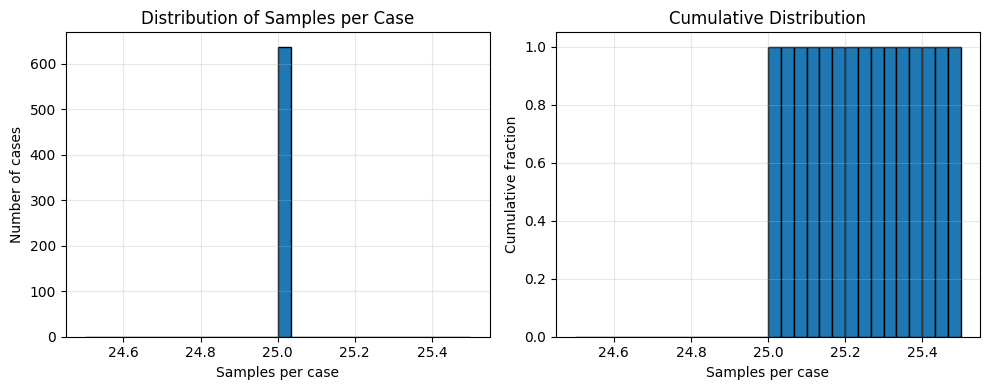


Interpretation: Each case has ~25 samples.
With random splitting, samples from the same case can appear in both train and test!


In [3]:
# Analyze case structure
unique_cases, case_counts = np.unique(case_ids, return_counts=True)

print(f"Case statistics:")
print(f"  Total unique cases: {len(unique_cases)}")
print(f"  Samples per case (min/mean/max): {case_counts.min()}/{case_counts.mean():.1f}/{case_counts.max()}")

# Show distribution
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(case_counts, bins=30, edgecolor='black')
plt.xlabel('Samples per case')
plt.ylabel('Number of cases')
plt.title('Distribution of Samples per Case')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(case_counts, bins=30, edgecolor='black', cumulative=True, density=True)
plt.xlabel('Samples per case')
plt.ylabel('Cumulative fraction')
plt.title('Cumulative Distribution')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nInterpretation: Each case has ~{case_counts.mean():.0f} samples.")
print(f"With random splitting, samples from the same case can appear in both train and test!")

## 3. PROBLEM: Random Splitting Creates Leakage

Let's use the old random splitting method and check for leakage.

In [4]:
print("Testing OLD method: Random splitting (has leakage!)")
print("="*60)

# Use old prepare_data function (random split)
data_random = prepare_data(strains_voigt, stresses, test_size=0.2, val_size=0.2, 
                          random_state=42, scale=False)

print(f"\nSplit sizes:")
print(f"  Train: {data_random['splits']['train']} samples")
print(f"  Val:   {data_random['splits']['val']} samples")
print(f"  Test:  {data_random['splits']['test']} samples")

Testing OLD method: Random splitting (has leakage!)

Split sizes:
  Train: 9555 samples
  Val:   3185 samples
  Test:  3185 samples


In [5]:
# Now let's check for case leakage manually
from sklearn.model_selection import train_test_split

# Recreate the split to get indices
X_train_val, X_test, y_train_val, y_test, case_train_val, case_test = train_test_split(
    strains_voigt, stresses, case_ids, test_size=0.2, random_state=42
)

val_size_adjusted = 0.2 / (1 - 0.2)
X_train, X_val, y_train, y_val, case_train, case_val = train_test_split(
    X_train_val, y_train_val, case_train_val, test_size=val_size_adjusted, random_state=42
)

# Check for overlapping cases
train_cases = set(case_train)
val_cases = set(case_val)
test_cases = set(case_test)

overlap_train_val = train_cases & val_cases
overlap_train_test = train_cases & test_cases
overlap_val_test = val_cases & test_cases

print("\n" + "="*60)
print("LEAKAGE DETECTION RESULTS (Random Splitting)")
print("="*60)
print(f"\nUnique cases in each split:")
print(f"  Train: {len(train_cases)} cases")
print(f"  Val:   {len(val_cases)} cases")
print(f"  Test:  {len(test_cases)} cases")

print(f"\n⚠️  LEAKAGE DETECTED:")
print(f"  Cases in both Train & Val:  {len(overlap_train_val)}")
print(f"  Cases in both Train & Test: {len(overlap_train_test)}")
print(f"  Cases in both Val & Test:   {len(overlap_val_test)}")

total_unique_cases = len(np.unique(case_ids))
leakage_percentage = (len(overlap_train_test) / total_unique_cases) * 100
print(f"\n❌ {leakage_percentage:.1f}% of cases appear in BOTH training and test!")
print(f"   This makes evaluation overly optimistic and unrealistic.")


LEAKAGE DETECTION RESULTS (Random Splitting)

Unique cases in each split:
  Train: 637 cases
  Val:   633 cases
  Test:  635 cases

⚠️  LEAKAGE DETECTED:
  Cases in both Train & Val:  633
  Cases in both Train & Test: 635
  Cases in both Val & Test:   631

❌ 99.7% of cases appear in BOTH training and test!
   This makes evaluation overly optimistic and unrealistic.


## 4. SOLUTION: Case-Based Splitting

Now let's use the new `prepare_data_by_groups()` function that splits by case.

In [6]:
print("Testing NEW method: Case-based splitting (no leakage!)")
print("="*60)

# Use new prepare_data_by_groups function
data_by_case = prepare_data_by_groups(
    strains_voigt, 
    stresses, 
    group_ids=case_ids,
    test_size=0.2, 
    val_size=0.2,
    random_state=42, 
    scale=False,
    split_by='case'
)

Testing NEW method: Case-based splitting (no leakage!)
Splitting by case: 637 unique groups
  Train: 381 groups, 9525 samples
  Val:   128 groups, 3200 samples
  Test:  128 groups, 3200 samples
  ✓ No group leakage detected


In [7]:
# Validate no leakage
print("\n" + "="*60)
print("VALIDATION")
print("="*60)
validate_no_leakage(data_by_case)


VALIDATION
✓ No group leakage between train/val/test splits


True

## 5. Compare Sample Distributions

Check if case-based splitting maintains reasonable scenario distribution.

In [8]:
# Get scenario labels for each split
from sklearn.model_selection import train_test_split as tts

# For case-based split, get scenario distribution
train_mask_case = np.isin(case_ids, data_by_case['groups']['train'])
val_mask_case = np.isin(case_ids, data_by_case['groups']['val'])
test_mask_case = np.isin(case_ids, data_by_case['groups']['test'])

scenarios_train_case = scenario_labels[train_mask_case]
scenarios_val_case = scenario_labels[val_mask_case]
scenarios_test_case = scenario_labels[test_mask_case]

print("Scenario distribution with case-based splitting:")
print("\nTrain set:")
unique_train, counts_train = np.unique(scenarios_train_case, return_counts=True)
for scenario, count in zip(unique_train, counts_train):
    print(f"  {scenario:<30} {count:>5} samples")

print("\nValidation set:")
unique_val, counts_val = np.unique(scenarios_val_case, return_counts=True)
for scenario, count in zip(unique_val, counts_val):
    print(f"  {scenario:<30} {count:>5} samples")

print("\nTest set:")
unique_test, counts_test = np.unique(scenarios_test_case, return_counts=True)
for scenario, count in zip(unique_test, counts_test):
    print(f"  {scenario:<30} {count:>5} samples")

Scenario distribution with case-based splitting:

Train set:
  biaxial_2to1                     425 samples
  equibiaxial                      425 samples
  equibiaxial_compression          325 samples
  phi_45_plane                     350 samples
  pure_shear                       475 samples
  radial_45_45                     475 samples
  simple_shear                     425 samples
  sphere                          5150 samples
  uniaxial_x                       375 samples
  uniaxial_x_compression           350 samples
  uniaxial_y                       350 samples
  uniaxial_y_compression           400 samples

Validation set:
  biaxial_2to1                     100 samples
  equibiaxial                       50 samples
  equibiaxial_compression          125 samples
  phi_45_plane                     100 samples
  pure_shear                        50 samples
  radial_45_45                      25 samples
  simple_shear                      75 samples
  sphere                     

## 6. Visual Comparison

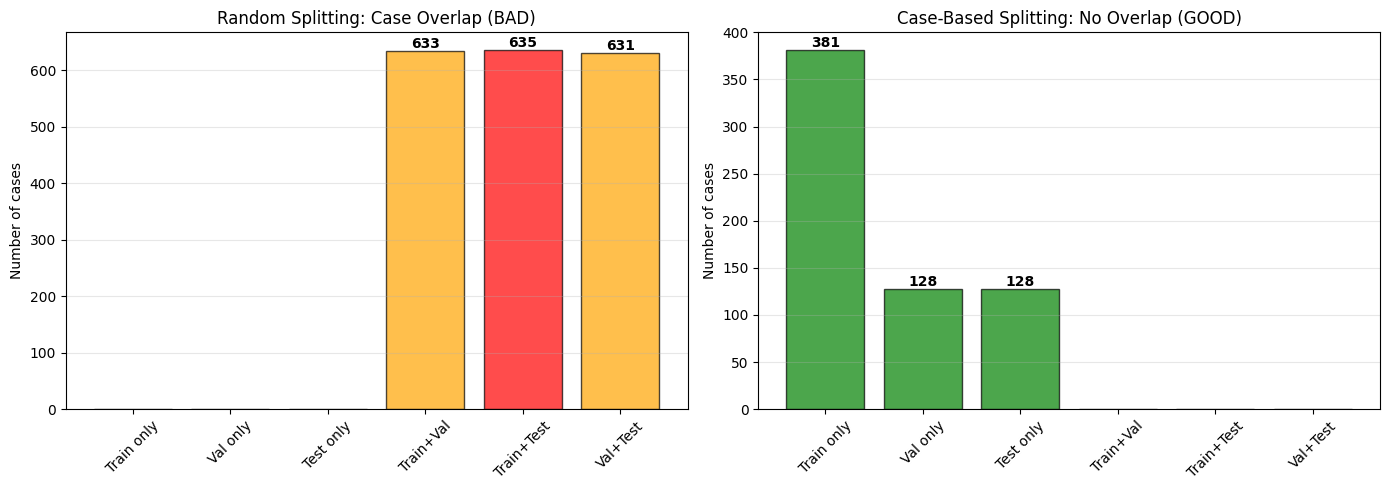


✓ Case-based splitting ensures no case appears in multiple splits!


In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Case overlap with random splitting
ax1 = axes[0]
categories = ['Train only', 'Val only', 'Test only', 'Train+Val', 'Train+Test', 'Val+Test']
counts_random = [
    len(train_cases - val_cases - test_cases),
    len(val_cases - train_cases - test_cases),
    len(test_cases - train_cases - val_cases),
    len(overlap_train_val),
    len(overlap_train_test),
    len(overlap_val_test)
]
colors = ['green', 'green', 'green', 'orange', 'red', 'orange']
ax1.bar(categories, counts_random, color=colors, alpha=0.7, edgecolor='black')
ax1.set_ylabel('Number of cases')
ax1.set_title('Random Splitting: Case Overlap (BAD)')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3, axis='y')

# Add text annotations
for i, (cat, count) in enumerate(zip(categories, counts_random)):
    if count > 0:
        ax1.text(i, count, str(count), ha='center', va='bottom', fontweight='bold')

# Plot 2: Case distribution with case-based splitting
ax2 = axes[1]
train_cases_proper = set(data_by_case['groups']['train'])
val_cases_proper = set(data_by_case['groups']['val'])
test_cases_proper = set(data_by_case['groups']['test'])

counts_proper = [
    len(train_cases_proper),
    len(val_cases_proper),
    len(test_cases_proper),
    0,  # No overlap
    0,  # No overlap
    0   # No overlap
]
colors_proper = ['green', 'green', 'green', 'green', 'green', 'green']
ax2.bar(categories, counts_proper, color=colors_proper, alpha=0.7, edgecolor='black')
ax2.set_ylabel('Number of cases')
ax2.set_title('Case-Based Splitting: No Overlap (GOOD)')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3, axis='y')

# Add text annotations
for i, (cat, count) in enumerate(zip(categories, counts_proper)):
    if count > 0:
        ax2.text(i, count, str(count), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ Case-based splitting ensures no case appears in multiple splits!")

## 7. Expected Impact on Model Performance

Let's discuss what we expect to see when we switch to case-based splitting.

In [10]:
print("="*70)
print("EXPECTED IMPACT OF FIXING DATA LEAKAGE")
print("="*70)

print("\n1. TEST PERFORMANCE WILL DECREASE")
print("   - Current R² values are INFLATED due to leakage")
print("   - With proper splitting, R² will be LOWER but more HONEST")
print("   - This is GOOD - shows true generalization capability")

print("\n2. TRAIN-TEST GAP WILL INCREASE")
print("   - Gap between train and test performance will grow")
print("   - This reveals the true difficulty of generalization")

print("\n3. PANN MAY SHOW BETTER RELATIVE PERFORMANCE")
print("   - Physics constraints may help PANN generalize better")
print("   - PANN's advantage over baseline may become more apparent")
print("   - This would validate the physics-informed approach")

print("\n4. MORE MEANINGFUL COMPARISONS")
print("   - All model comparisons will be on truly unseen data")
print("   - Results will better reflect real-world performance")

print("\n" + "="*70)
print("RECOMMENDATION: Update all notebooks to use prepare_data_by_groups()")
print("="*70)

EXPECTED IMPACT OF FIXING DATA LEAKAGE

1. TEST PERFORMANCE WILL DECREASE
   - Current R² values are INFLATED due to leakage
   - With proper splitting, R² will be LOWER but more HONEST
   - This is GOOD - shows true generalization capability

2. TRAIN-TEST GAP WILL INCREASE
   - Gap between train and test performance will grow
   - This reveals the true difficulty of generalization

3. PANN MAY SHOW BETTER RELATIVE PERFORMANCE
   - Physics constraints may help PANN generalize better
   - PANN's advantage over baseline may become more apparent
   - This would validate the physics-informed approach

4. MORE MEANINGFUL COMPARISONS
   - All model comparisons will be on truly unseen data
   - Results will better reflect real-world performance

RECOMMENDATION: Update all notebooks to use prepare_data_by_groups()


## Summary

### Problem Identified
- Random splitting causes **data leakage**: samples from the same experimental case appear in both training and test sets
- This makes evaluation **overly optimistic** and not representative of true generalization

### Solution Implemented
- New `prepare_data_by_groups()` function splits by **case ID**
- Ensures all samples from a case stay together in one split
- **Validated**: No overlap between train/val/test cases

### Next Steps
1. Update `baseline_analysis.ipynb` to use case-based splitting
2. Update `pann_analysis.ipynb` to use case-based splitting
3. Update `comparison.ipynb` to ensure consistent splits
4. Update `generalization_test.ipynb` for internal train/val/test split
5. Re-run all experiments and compare results

### Expected Outcome
More honest evaluation of model performance and clearer demonstration of PANN's generalization advantages.